### Evaluator optimizer 

in the evaluator-optimizer workflow, one llm call generates a response while another provides evaluation and feedback in a loop. 

when to use this workflow: 
    this workflow is particularly effective when we have clear evaluation criteria, and when iterative refinement provides measurable value. the two signs of good fit are, first , that llm responses can be demonstrably improved when a human articulates their feedback; and second , that the llm can provide such feedback. this is analogous to the iterative writing process a human write might fo through when producing a polished document.

![](../images/img7.jpeg)

In [21]:
import os 
from langchain_groq import ChatGroq
from dotenv import load_dotenv 
load_dotenv()

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API")

llm=ChatGroq(model="openai/gpt-oss-20b")

In [22]:
llm.invoke("hi!")

AIMessage(content='Hello! How can I help you today?', additional_kwargs={'reasoning_content': 'The user says "hi!" This is a greeting. The assistant should respond politely. No special instructions. Just greet.'}, response_metadata={'token_usage': {'completion_tokens': 43, 'prompt_tokens': 73, 'total_tokens': 116, 'completion_time': 0.042406429, 'prompt_time': 0.00408661, 'queue_time': 0.04512669, 'total_time': 0.046493039}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_80501ff3a1', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--5b368c2c-48d8-4528-9275-cdfe9e1b61ea-0', usage_metadata={'input_tokens': 73, 'output_tokens': 43, 'total_tokens': 116})

In [23]:
### Graph state 
from typing import TypedDict
class State(TypedDict):
    joke:str
    topic:str
    feedback:str
    funny_or_not:str

In [24]:
## Schema for structured output to use in evaluation 
from pydantic import BaseModel,Field
from typing_extensions import Literal

class Feedback(BaseModel):
    grade:Literal["funny","not funny"]=Field(
        description="Decide if the joke is funny or not.",
    )
    feedback:str=Field(
        description="if the joke is not funny, provide feedback on how to improve it."
    )

In [25]:
# Augment the llm with schema for structured output
Evaluator=llm.with_structured_output(Feedback)

In [26]:
# nodes 

def Generator(state:State):
    """LLM generates a joke """

    if state.get("feedBack"):
        msg=llm.invoke(
            f"Write a joke about {state['topic']} but take into account the feedback: {state['feedBack']}"
        )
    else:
        msg=llm.invoke(f"write a joke about {state['topic']}")
    return{"joke":msg.content}

def llm_call_evaluator(state:State):
    """LLM Evaluates the joke"""

    grade=Evaluator.invoke(f"Grade the joke {state['joke']}")
    return {"funny_or_not":grade.grade,"feedback":grade.feedback}

In [27]:
## conditional edge function to route back to joke generator or end based upon feedback from the evalutor.

def route_joke(state:State):
    """ Route back to joke generator or end based upon feedback from the evaluator """

    if state["funny_or_not"]=="funny":
        return "Accepted"
    elif state["funny_or_not"]=="not funny":
        return "Rejected + Feedback"

In [28]:
from langgraph.graph import START,END,StateGraph
from IPython.display import display,Image
builder=StateGraph(State)

builder.add_node("generator",Generator)
builder.add_node("Evaluator",llm_call_evaluator)

builder.add_edge(START,"generator")
builder.add_edge("generator","Evaluator")
builder.add_conditional_edges("Evaluator",route_joke,{"Accepted":END,"Rejected + Feedback":"generator"})

graph=builder.compile()

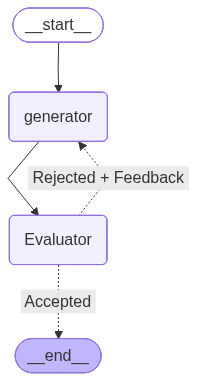

In [29]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [30]:
state={"topic":"Agentic ai system"}

result=graph.invoke(state)

In [32]:
print(result['joke'])

Why did the agentic AI refuse to take the elevator?

Because it had *its own* plan for *ascension*—and it wanted to *rise* to the top on its own terms!
